In [4]:
!pip install rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a32336caee860aee33fb20d9449058751516567c774709d7f6a602b37aa82cf5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
from datasets import load_dataset
import torch
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    AutoConfig
)
import time
import re
from rouge_score import rouge_scorer


In [6]:

# Function to clean and preprocess text
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()


In [8]:
# Load dataset
dataset = load_dataset("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail", 'default')
dataset = dataset.shuffle(seed=42)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [150]:

# Split into train, validation, and test sets
train_size, val_size, test_size = 21000, 6000, 3000
train_dataset = dataset['train'].select(range(train_size))
val_dataset = dataset['train'].select(range(train_size, train_size + val_size))
test_dataset = dataset['train'].select(range(train_size + val_size, train_size + val_size + test_size))



In [151]:
# Print sizes of the splits to verify
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 21000
Validation set size: 6000
Test set size: 3000


In [152]:
# Prepare and clean stories and summaries
stories = [clean_text(item['article']) for item in train_dataset]
summaries = [clean_text(item['highlights']) for item in train_dataset]

# Limit story length to be greater than summary length and apply maximum length constraint
final_stories, final_summaries = [], []
for story, summary in zip(stories, summaries):
    if len(story.split()) >= len(summary.split()) and len(story.split()) < 495:
        final_stories.append(story)
        final_summaries.append(summary)
    if len(final_stories) > 35000:
        break

print(f"Final train stories count: {len(final_stories)}")
print(f"Final train summaries count: {len(final_summaries)}")


Final train stories count: 7131
Final train summaries count: 7131


In [153]:
import torch
from transformers import GPT2Tokenizer, AutoConfig, GPT2LMHeadModel
from torch import nn
import torch.nn.functional as F

# Initialize the tokenizer and model, freeze model parameters
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Freeze the GPT-2 model parameters
for param in model.parameters():
    param.requires_grad = False

# Define the Soft Prompt Embedding layer
class SoftPromptModel(nn.Module):
    def __init__(self, model, num_prompts, embedding_size):
        super(SoftPromptModel, self).__init__()
        self.model = model
        self.num_prompts = num_prompts
        self.embedding_size = embedding_size

        # Define the soft prompt embedding layer with dimensions [num_prompts, embedding_size]
        self.soft_prompt_embeddings = nn.Embedding(num_prompts, embedding_size)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get the soft prompt embeddings and expand to match the batch size
        batch_size = input_ids.size(0)
        soft_prompt_ids = torch.arange(self.num_prompts).unsqueeze(0).to(input_ids.device)
        soft_prompt_embeddings = self.soft_prompt_embeddings(soft_prompt_ids)
        soft_prompt_embeddings = soft_prompt_embeddings.expand(batch_size, -1, -1)

        # Get the token embeddings from the model's input embeddings
        input_embeddings = self.model.transformer.wte(input_ids)
        
        # Prepend the soft prompt embeddings to the input embeddings
        inputs_embeds = torch.cat([soft_prompt_embeddings, input_embeddings], dim=1)

        # Extend attention mask to cover soft prompts
        if attention_mask is not None:
            soft_prompt_attention_mask = torch.ones((batch_size, self.num_prompts), device=input_ids.device)
            attention_mask = torch.cat([soft_prompt_attention_mask, attention_mask], dim=1)

        # Forward pass through GPT-2 with modified inputs_embeds and attention_mask
        output = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        
        # Compute the loss if labels are provided
        loss = None
        if labels is not None:
            # Shift labels and input embeddings to match dimensions for loss calculation
            shift_logits = output.logits[..., self.num_prompts:-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            # Compute loss using CrossEntropyLoss, ignoring padding tokens
            loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        return {"loss": loss, "logits": output.logits}

# Set hyperparameters for the soft prompt
num_prompts = 3  # Define the number of prompt tokens
embedding_size = model.config.hidden_size  # 768 for GPT-2 small

# Initialize the soft prompt model with the frozen GPT-2 model and soft prompt embeddings
soft_prompt_model = SoftPromptModel(model, num_prompts, embedding_size)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [154]:

# Initialize the soft prompt model with the frozen GPT-2 model and soft prompt embeddings
model = SoftPromptModel(model, num_prompts, embedding_size)

In [155]:
# Print trainable parameters to verify
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")
    else:
        print(f"{name} is frozen")

model.transformer.wte.weight is frozen
model.transformer.wpe.weight is frozen
model.transformer.h.0.ln_1.weight is frozen
model.transformer.h.0.ln_1.bias is frozen
model.transformer.h.0.attn.c_attn.weight is frozen
model.transformer.h.0.attn.c_attn.bias is frozen
model.transformer.h.0.attn.c_proj.weight is frozen
model.transformer.h.0.attn.c_proj.bias is frozen
model.transformer.h.0.ln_2.weight is frozen
model.transformer.h.0.ln_2.bias is frozen
model.transformer.h.0.mlp.c_fc.weight is frozen
model.transformer.h.0.mlp.c_fc.bias is frozen
model.transformer.h.0.mlp.c_proj.weight is frozen
model.transformer.h.0.mlp.c_proj.bias is frozen
model.transformer.h.1.ln_1.weight is frozen
model.transformer.h.1.ln_1.bias is frozen
model.transformer.h.1.attn.c_attn.weight is frozen
model.transformer.h.1.attn.c_attn.bias is frozen
model.transformer.h.1.attn.c_proj.weight is frozen
model.transformer.h.1.attn.c_proj.bias is frozen
model.transformer.h.1.ln_2.weight is frozen
model.transformer.h.1.ln_2.b

In [156]:
# Count trainable and frozen parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Frozen parameters: {frozen_params}")

Trainable parameters: 2304
Frozen parameters: 124439808


In [157]:
# Dataset class for PyTorch
class SummDataset(torch.utils.data.Dataset):
    def __init__(self, stories_list, summaries_list):
        self.stor_list = stories_list
        self.sum_list = summaries_list
        self.max_length = 500

    def encode(self, text):
        return tokenizer.encode(text, return_tensors="pt", max_length=self.max_length, truncation=True, padding="max_length")

    def __len__(self):
        return len(self.stor_list)

    def __getitem__(self, index):
        story = self.encode(self.stor_list[index]).squeeze(0)
        summary = self.encode(self.sum_list[index]).squeeze(0)
        return {
            'input_ids': story,
            'labels': summary
        }


In [158]:
print(val_dataset[0])

{'id': 'f12b2293dd1351160f08b5484f0d5ca2d6aa1aef', 'article': "CLICK HERE to read Matt Lawton assessment of Roy Keane's explosive press conference . Gordon Strachan will exercise his right of reply to Roy Keane's book comments after Scotland's 2016 European Championship qualifying double-header against Georgia and Poland. In his explosive new autobiography, the Irishman said defiance underpinned his move to Celtic in January 2006, as he claimed that then Hoops boss Strachan was less than enthusiastic. VIDEO Scroll down to see what happened when a phone interrupted Keane's book launch . Gordon Strachan (L) and Roy Keane pose with the shirt after midfielder signed for Celtic in 2006 . Keane has claimed in his autobiography that he only signed for the Hoops to defy manager Strachan . Keane retired from playing six months after joining Celtic and collecting a domestic double . Keane said: 'I met Gordon Strachan in London at Dermot Desmond's (Celtic majority shareholder) house. 'Gordon told

In [159]:
# Create dataset instances
train_dataset = SummDataset(final_stories, final_summaries)
# val_stories = [clean_text(item['article']) for item in val_dataset]
# val_summaries = [clean_text(item['highlights']) for item in val_dataset]
val_stories = [clean_text(item['article']) for item in val_dataset][:200]
val_summaries = [clean_text(item['highlights']) for item in val_dataset][:200]

val_dataset=SummDataset(val_stories, val_summaries)



In [160]:
test_stories = [clean_text(item['article']) for item in test_dataset]
test_summaries = [clean_text(item['highlights']) for item in test_dataset]

test_dataset=SummDataset(test_stories, test_summaries)
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [200]:

# Define the compute_metrics function for ROUGE score calculation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge-1': 0.0,
        'rouge-2': 0.0,
        'rouge-l': 0.0,
    }
    for pred, label in zip(decoded_preds, decoded_labels):
        score = scorer.score(label, pred)
        scores['rouge-1'] += score['rouge1'].fmeasure
        scores['rouge-2'] += score['rouge2'].fmeasure
        scores['rouge-l'] += score['rougeL'].fmeasure

    # Average scores
    total = len(decoded_preds)
    scores = {k: v / total for k, v in scores.items()}
    return scores



In [173]:
!rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [174]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, EarlyStoppingCallback


In [175]:

# Define training arguments
training_args = TrainingArguments(
    output_dir="Final_results",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    save_steps=100,
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none",
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_safetensors=False
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [176]:
# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)



In [177]:
# Training
start_time = time.time()
trainer.train()
trainer.save_model(training_args.output_dir)
training_time = time.time() - start_time

Step,Training Loss,Validation Loss
100,9.733300,10.047009
200,9.641100,9.978683
300,9.508800,9.912032
400,9.446300,9.844051
500,9.489100,9.774864
600,9.292400,9.714208
700,9.287000,9.660138
800,9.303300,9.617360
900,9.237100,9.581841
1000,9.164700,9.537551


In [178]:
# Evaluate
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

# Number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

# Estimate GPU compute (in FLOPs)
flops = 2 * num_params * (training_args.per_device_train_batch_size * training_args.num_train_epochs)
print(f"Estimated FLOPs: {flops}")

# GPU memory usage
gpu_memory = torch.cuda.memory_allocated() / (1024**2)  # Convert to MB
print(f"GPU memory allocated: {gpu_memory:.2f} MB")


Evaluation results: {'eval_loss': 8.934844017028809, 'eval_runtime': 6.0305, 'eval_samples_per_second': 33.165, 'eval_steps_per_second': 4.146, 'epoch': 3.0}
Number of trainable parameters: 2304
Estimated FLOPs: 27648
GPU memory allocated: 1975.33 MB


In [227]:
# Trainer initialization
test_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)



In [ ]:
# Evaluate
evaluation_results = test_trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")


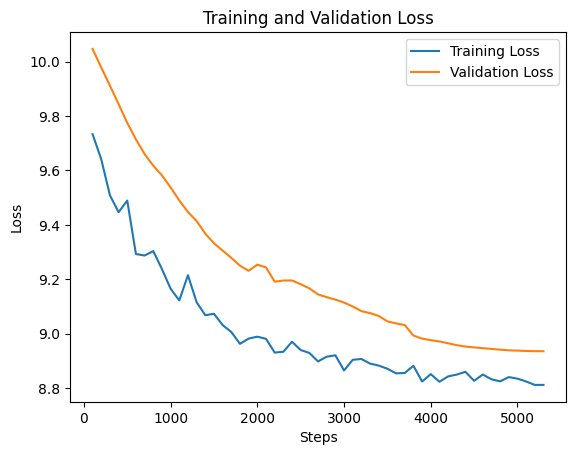

In [1]:
import matplotlib.pyplot as plt

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300]

training_loss = [9.733300, 9.641100, 9.508800, 9.446300, 9.489100, 9.292400, 9.287000, 9.303300, 9.237100, 9.164700, 9.121800, 9.214600, 9.115000, 9.067400, 9.072600, 9.031000, 9.005600, 8.962000, 8.981400, 8.988400, 8.980500, 8.929900, 8.932900, 8.969700, 8.939200, 8.928700, 8.897300, 8.914800, 8.919800, 8.864100, 8.903300, 8.906300, 8.889300, 8.882000, 8.870400, 8.853400, 8.854900, 8.881300, 8.823400, 8.850700, 8.822500, 8.842200, 8.849000, 8.859100, 8.826000, 8.849200, 8.831600, 8.824000, 8.839700, 8.833900, 8.823600, 8.810900, 8.811000]

validation_loss = [10.047009, 9.978683, 9.912032, 9.844051, 9.774864, 9.714208, 9.660138, 9.617360, 9.581841, 9.537551, 9.489642, 9.447174, 9.413887, 9.367474, 9.331943, 9.305124, 9.278263, 9.249636, 9.230726, 9.253292, 9.243222, 9.190871, 9.194952, 9.195110, 9.181402, 9.166047, 9.143859, 9.133821, 9.124765, 9.113955, 9.099448, 9.082402, 9.074991, 9.064612, 9.044688, 9.037215, 9.031110, 8.992579, 8.981241, 8.975641, 8.970699, 8.964128, 8.956992, 8.952076, 8.949098, 8.945980, 8.943409, 8.940526, 8.938280, 8.937083, 8.935840, 8.935086, 8.934844]

# Plot the training and validation loss
plt.plot(steps, training_loss, label="Training Loss")
plt.plot(steps, validation_loss, label="Validation Loss")

# Set the plot title and labels
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Display the plot
plt.show()